In [2]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
import math
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 提取主力合约数据，已经加入了MA、EMA、MACD等指标

In [93]:
# 提取训练数据和测试数据
path = '/home/chocolate/LSTM-source/'
data = pd.read_csv(path + 'train_data_addMA.csv')
data=data.ix[:,2:]
data = data.fillna(0)
data['RaiseDown'] = (data['Latestprice'] - data['First.Latestprice'])/data['First.Latestprice']

In [94]:
data_array = np.array(data)
data_array

array([[  3.64040000e+03,   3.64600000e+03,   3.64020000e+03, ...,
          0.00000000e+00,   0.00000000e+00,  -1.20719930e-03],
       [  3.62580000e+03,   3.64140000e+03,   3.62440000e+03, ...,
         -1.81980057e-01,  -2.91168091e-01,  -4.01054829e-03],
       [  3.61880000e+03,   3.62680000e+03,   3.61260000e+03, ...,
         -3.67419077e-01,  -5.34064377e-01,  -1.82048877e-03],
       ..., 
       [  3.30420000e+03,   3.30680000e+03,   3.30420000e+03, ...,
          7.50627102e-01,  -6.88750506e-01,  -4.83997822e-04],
       [  3.30480000e+03,   3.30540000e+03,   3.30380000e+03, ...,
          6.55617336e-01,  -7.60078129e-01,   1.81587071e-04],
       [  3.30500000e+03,   3.30620000e+03,   3.30400000e+03, ...,
          5.61696391e-01,  -7.51367561e-01,   0.00000000e+00]])

## 对数据进行标准化

In [95]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_array = min_max_scaler.fit_transform(data_array)
data_array

array([[ 1.        ,  1.        ,  1.        , ...,  0.71291684,
         0.65315817,  0.66115234],
       [ 0.98349537,  0.9947952 ,  0.98259529, ...,  0.71030444,
         0.64915289,  0.56535632],
       [ 0.97558218,  0.97827563,  0.96959683, ...,  0.70764238,
         0.64581164,  0.64019502],
       ..., 
       [ 0.61994122,  0.61620276,  0.62987442, ...,  0.72369243,
         0.64368379,  0.68586557],
       [ 0.62061949,  0.61461869,  0.6294338 , ...,  0.72232852,
         0.64270261,  0.70860993],
       [ 0.62084558,  0.61552387,  0.62965411, ...,  0.72098024,
         0.64282244,  0.70240474]])

## 生成5分钟的时间序列，变为3维数组

In [96]:

seq_5 = []
for j in range(len(data_array)):
    if j+5 < len(data_array):
        seq_5.append(data_array[j:j+5])


In [97]:
seq_5 = np.array(seq_5)
seq_5.shape

(35753, 5, 32)

## 提取训练集、测试集。根据当前分钟的涨跌幅分别打标签，分为五类

In [98]:
train_data = seq_5[1000:21000]
train_data.shape

(20000, 5, 32)

In [99]:
data1 = data[1000:21000]
train_label = []
for i in data1['RaiseDown']:
    if i > 0.002:
        train_label.append([1,0,0,0,0])   #大涨
    elif i > 0.0005:
        train_label.append([0,1,0,0,0])   #小涨
    elif i> -0.0005: 
        train_label.append([0,0,1,0,0])   #平稳
    elif i > -0.002:
        train_label.append([0,0,0,1,0])   #小跌
    else:
        train_label.append([0,0,0,0,1])   #大跌
train_label = np.array(train_label)
train_label.shape

(20000, 5)

In [100]:
train_label_list = train_label.tolist()
print train_label_list.count([1,0,0,0,0])
print train_label_list.count([0,1,0,0,0])
print train_label_list.count([0,0,1,0,0])
print train_label_list.count([0,0,0,1,0])
print train_label_list.count([0,0,0,0,1])

540
4356
10067
4583
454


In [101]:
test_data = seq_5[21000:23000]
test_data = np.array(test_data)
test_data.shape

(2000, 5, 32)

In [102]:
data2 = data[21000:23000]
test_label = []
for i in data2['RaiseDown']:
    if i > 0.002:
        test_label.append([1,0,0,0,0])
    elif i > 0.0005:
        test_label.append([0,1,0,0,0])
    elif i> -0.0005:
        test_label.append([0,0,1,0,0])
    elif i > -0.002:
        test_label.append([0,0,0,1,0])
    else:
        test_label.append([0,0,0,0,1])
test_label = np.array(test_label)

In [103]:
test_label_list = test_label.tolist()
# 测试集五类样本的数量
print test_label_list.count([1,0,0,0,0])
print test_label_list.count([0,1,0,0,0])
print test_label_list.count([0,0,1,0,0])
print test_label_list.count([0,0,0,1,0])
print test_label_list.count([0,0,0,0,1])

16
240
1504
236
4


# 开始构建LSTM网络，进行分类准确率测试

In [134]:
learning_rate = 0.001 # 学习速率
training_iters = 20000  # 训练总步长
batch_size = 200  # 每小段步长
display_step = 10  # 每隔十小段显示输出

# 参数设置
n_input = 32 # 特征数量
n_steps = 5 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 5 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])
# xte = tf.placeholder("float", [None, n_steps, n_input])
# yte = tf.placeholder("float", [None,n_classes])
xtr1 = tf.placeholder("float", [None, n_input*n_steps])  
xte1 = tf.placeholder("float", [n_input*n_steps])  
# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # 获取输出和状态
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(step, batch_size):
    return train_data[(step-1)*batch_size:step*batch_size], train_label[(step-1)*batch_size:step*batch_size]
def next_batch_te(step, batch_size):
    return test_data[(step-1)*batch_size:step*batch_size], test_label[(step-1)*batch_size:step*batch_size]

Xtr1 = np.reshape(train_data, newshape=(-1, n_input*n_steps))  
Xte1 = np.reshape(test_data, newshape=(-1, n_input*n_steps)) 
Xtr2 = map(map, [float, float], Xtr1)
Xte2 = map(map, [float, float], Xte1)
Xtr3 = np.array(Xtr2)
Xte3 = np.array(Xte2)


# 作出预测值和真实标签的对比

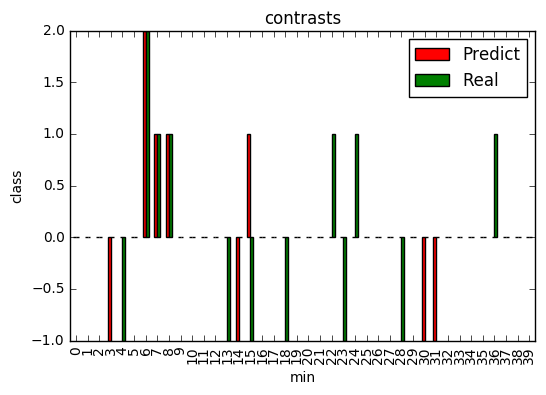

In [160]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-  
# 画出对比图，绿色表示实际值，红色表示预测值
%matplotlib inline
Y1=[]
for i in range(60,100):
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
    Y1.append(2 - np.argmax(train_label[nn_index]))
Y2=[]
for i in range(60,100):
    Y2.append(2 - np.argmax(test_label[i]))
import numpy as np    
import matplotlib.mlab as mlab    
import matplotlib.pyplot as plt    

Y3 = pd.concat([Series(Y1),Series(Y2)],axis=1)
Y3.columns = ['Predict','Real']
X=range(60,100)  
fig = plt.figure()  
Y3.plot(color=['red','green'],kind='bar',use_index=False)  
#plt.bar(X,Y2,0.4,color="red")  
plt.xlabel("min")  
plt.ylabel("class")  
plt.title("contrasts")  
